In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import math
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics
from labellines import labelLines

sys.path.append('..')
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

In [8]:
"""Set up environment, config, load pretrained model and datasets."""

results_dir = ".results/"
seed = 1
notebook_id = f"medmnist_{seed}"
model_path = ".models/medmnist.ckpt"  # pretrained model path
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
torch.manual_seed(seed)

batchsize = 5000
nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=0.2,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="WARNING",
    lr_decay=2.0,
    clip_gamma=1.0,
    lr_min=0.001,
    early_stopping=False,
    metadata=f"model={model_path}",
)

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

# get dataloaders, train dataloader is a mix of drusen and the "healthy" class
dl_train, _ = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1], balanced=True, shuffle=False)
_, dl_test_drusen = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1, 3], shuffle=False)
_, dl_test_other = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[2], shuffle=False)
_, dl_test_all = oct_mnist.get_dataloaders(batchsize, 1000, shuffle=False)

# get the pre-training accuracy on the drusen class
pretrain_acc = agt.test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_drusen)), model=model, transform=ct_utils.propagate_conv_layers
)[1]

In [5]:
"""Perform the sweep over different values of gamma and k_private/k_unlearn."""

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        torch.save((param_l, param_n, param_u), fname)
    # get nominal accuracy (on the Drusen class) and percent certified (on the entire test set)
    nominal_accuracy = test_metrics.test_accuracy(
        param_n, param_l, param_u, *next(iter(dl_test_drusen)), model=model, transform=ct_utils.propagate_conv_layers
    )[1]
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(dl_test_all)), model=model, transform=ct_utils.propagate_conv_layers
    )
    return nominal_accuracy, percent_certified

k_unlearning_vals = list(range(0, 2001, 100))
k_private_vals = list(range(0, 201, 10))
clip_gammas_privacy = clip_gammas_unlearning = [0.1, 0.5, 1.0, 2.0, 4.0]

unlearning_results = {}  # the results dictionary will be indexed by results[gamma][k_private]
config = copy.deepcopy(nominal_config)
for gamma in clip_gammas_unlearning:
    config.clip_gamma = gamma
    tmp_results = {}
    for k_unlearn in k_unlearning_vals:
        config.k_unlearn = k_unlearn
        tmp_results[k_unlearn] = run_with_config(config)
        print(f"\r{gamma=}, {k_unlearn=:5}", end="")
    unlearning_results[gamma] = tmp_results
    
privacy_results = {}  # the results dictionary will be indexed by results[gamma][k_private]

config = copy.deepcopy(nominal_config)
for gamma in clip_gammas_privacy:
    config.clip_gamma = gamma
    tmp_results = {}
    for k_private in k_private_vals:
        config.k_private = k_private
        tmp_results[k_private] = run_with_config(config)
        print(f"\r{gamma=}, {k_private=:5}", end="")
    privacy_results[gamma] = tmp_results
    

gamma=4.0, k_private=  200

In [6]:
"""Set up plotting environment."""

sns.set_theme(context="paper", style="whitegrid", font_scale=2.1)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

palette = ["#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"][::-1]
fontsize = "large"
labelsize = "small"
linewidth = 2

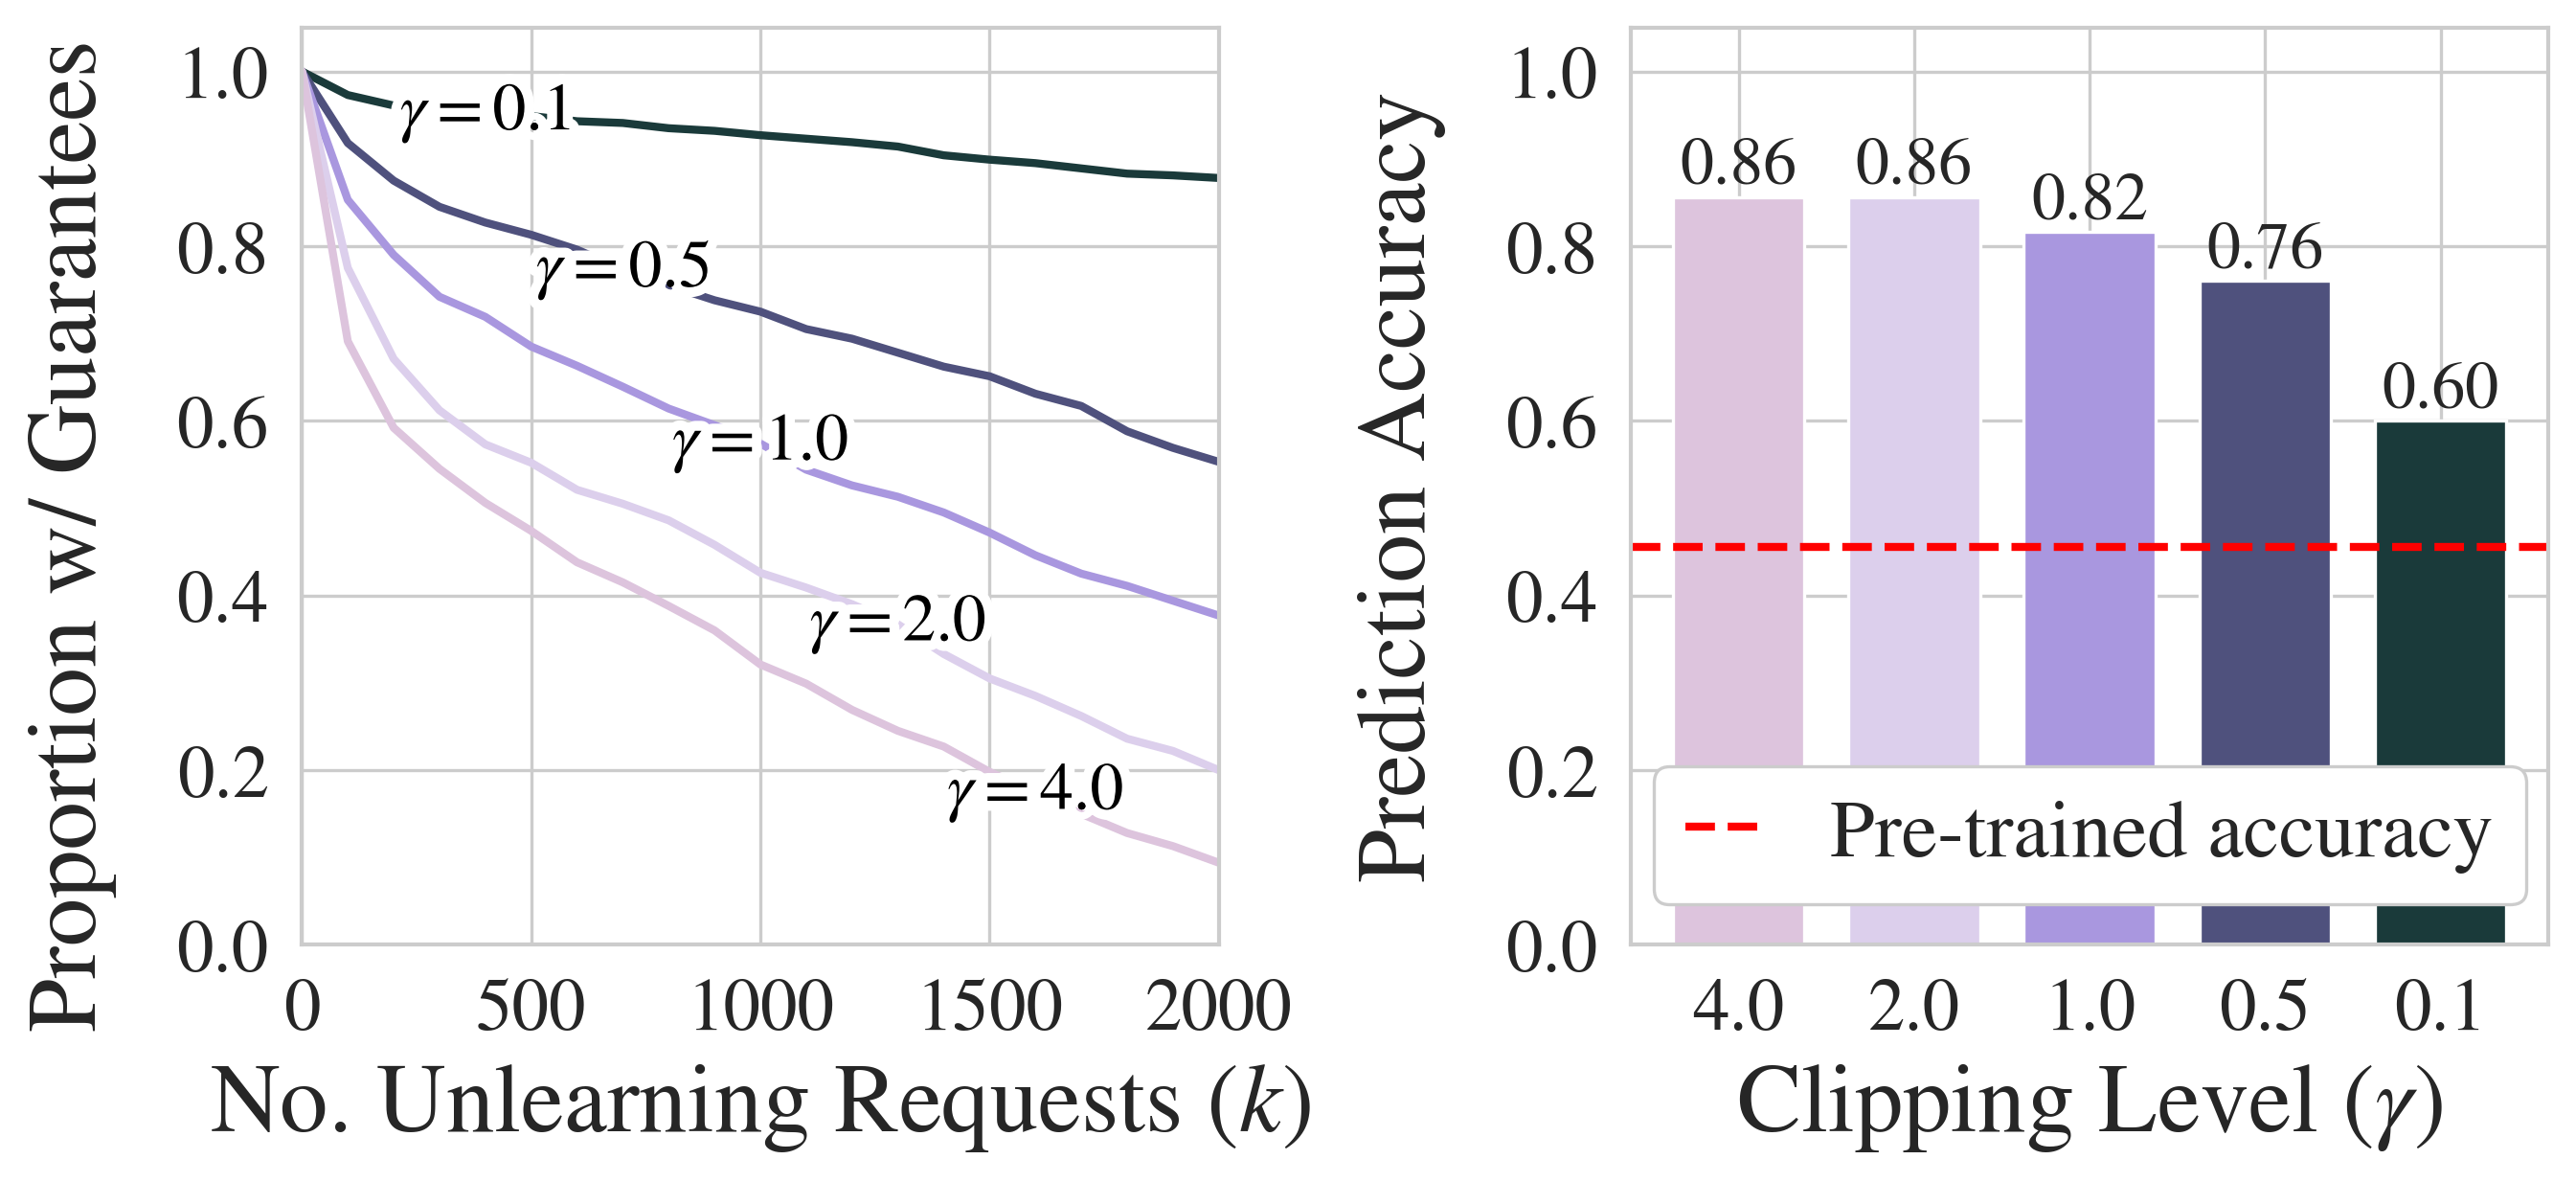

In [12]:
"""Plot the unlearning results."""
fig, axs = plt.subplots(1, 3, figsize=(9, 4), layout="constrained", width_ratios=[1, 0.01, 1], dpi=300)

axs[1].set_visible(False)
axs[0].set_box_aspect(1)
axs[2].set_box_aspect(1)

for ax in axs:    
    ax.set_ylim(0, 1.05)

colours = iter(palette)

for gamma, result in unlearning_results.items():
    k_vals = list(result.keys())
    certified_percentages = [r[1] for r in result.values()]
    label = f"$\gamma = {gamma}$" if gamma != math.inf else "$\gamma = \infty$"
    axs[0].plot(k_vals, certified_percentages, color=next(colours), label=label, linewidth=linewidth)
axs[0].set_xlabel("No. Unlearning Requests ($k$)", fontsize=fontsize)
axs[0].set_ylabel("Proportion w/ Guarantees    ", fontsize=fontsize, labelpad=15)
axs[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[0].set_xlim(0, max(k_unlearning_vals))
labelLines(
    axs[0].get_lines(),
    align=False,
    drop_label=True,
    fontsize=labelsize,
    color="black",
    outline_color="white",
    outline_width=5,
)

# plot the nominal accuracies on the second axis as a bar chart
bar_values = []
gamma_values = [str(g) if g != math.inf else "∞" for g in unlearning_results.keys()]
bar_colors = list(reversed(list(iter(palette))[: len(gamma_values)]))
for gamma, result in unlearning_results.items():
    nominal_accs = [r[0] for r in result.values()]
    bar_values.append(nominal_accs[0])
bars = axs[2].bar(gamma_values[::-1], bar_values[::-1], color=bar_colors, width=0.75)
axs[2].axhline(pretrain_acc, label="Pre-trained accuracy", color="red", linestyle="--", linewidth=linewidth)
axs[2].set_ylabel("Prediction Accuracy", fontsize=fontsize, labelpad=15)
axs[2].legend(loc="lower center", fontsize="medium", framealpha=1.0, handlelength=1.0)
axs[2].set_xlabel("Clipping Level ($\gamma$)", fontsize=fontsize)

# Add height labels to each bar
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize="small")

plt.savefig(".figures/oct_mnist_unlearning.pdf", bbox_inches="tight", dpi=300)

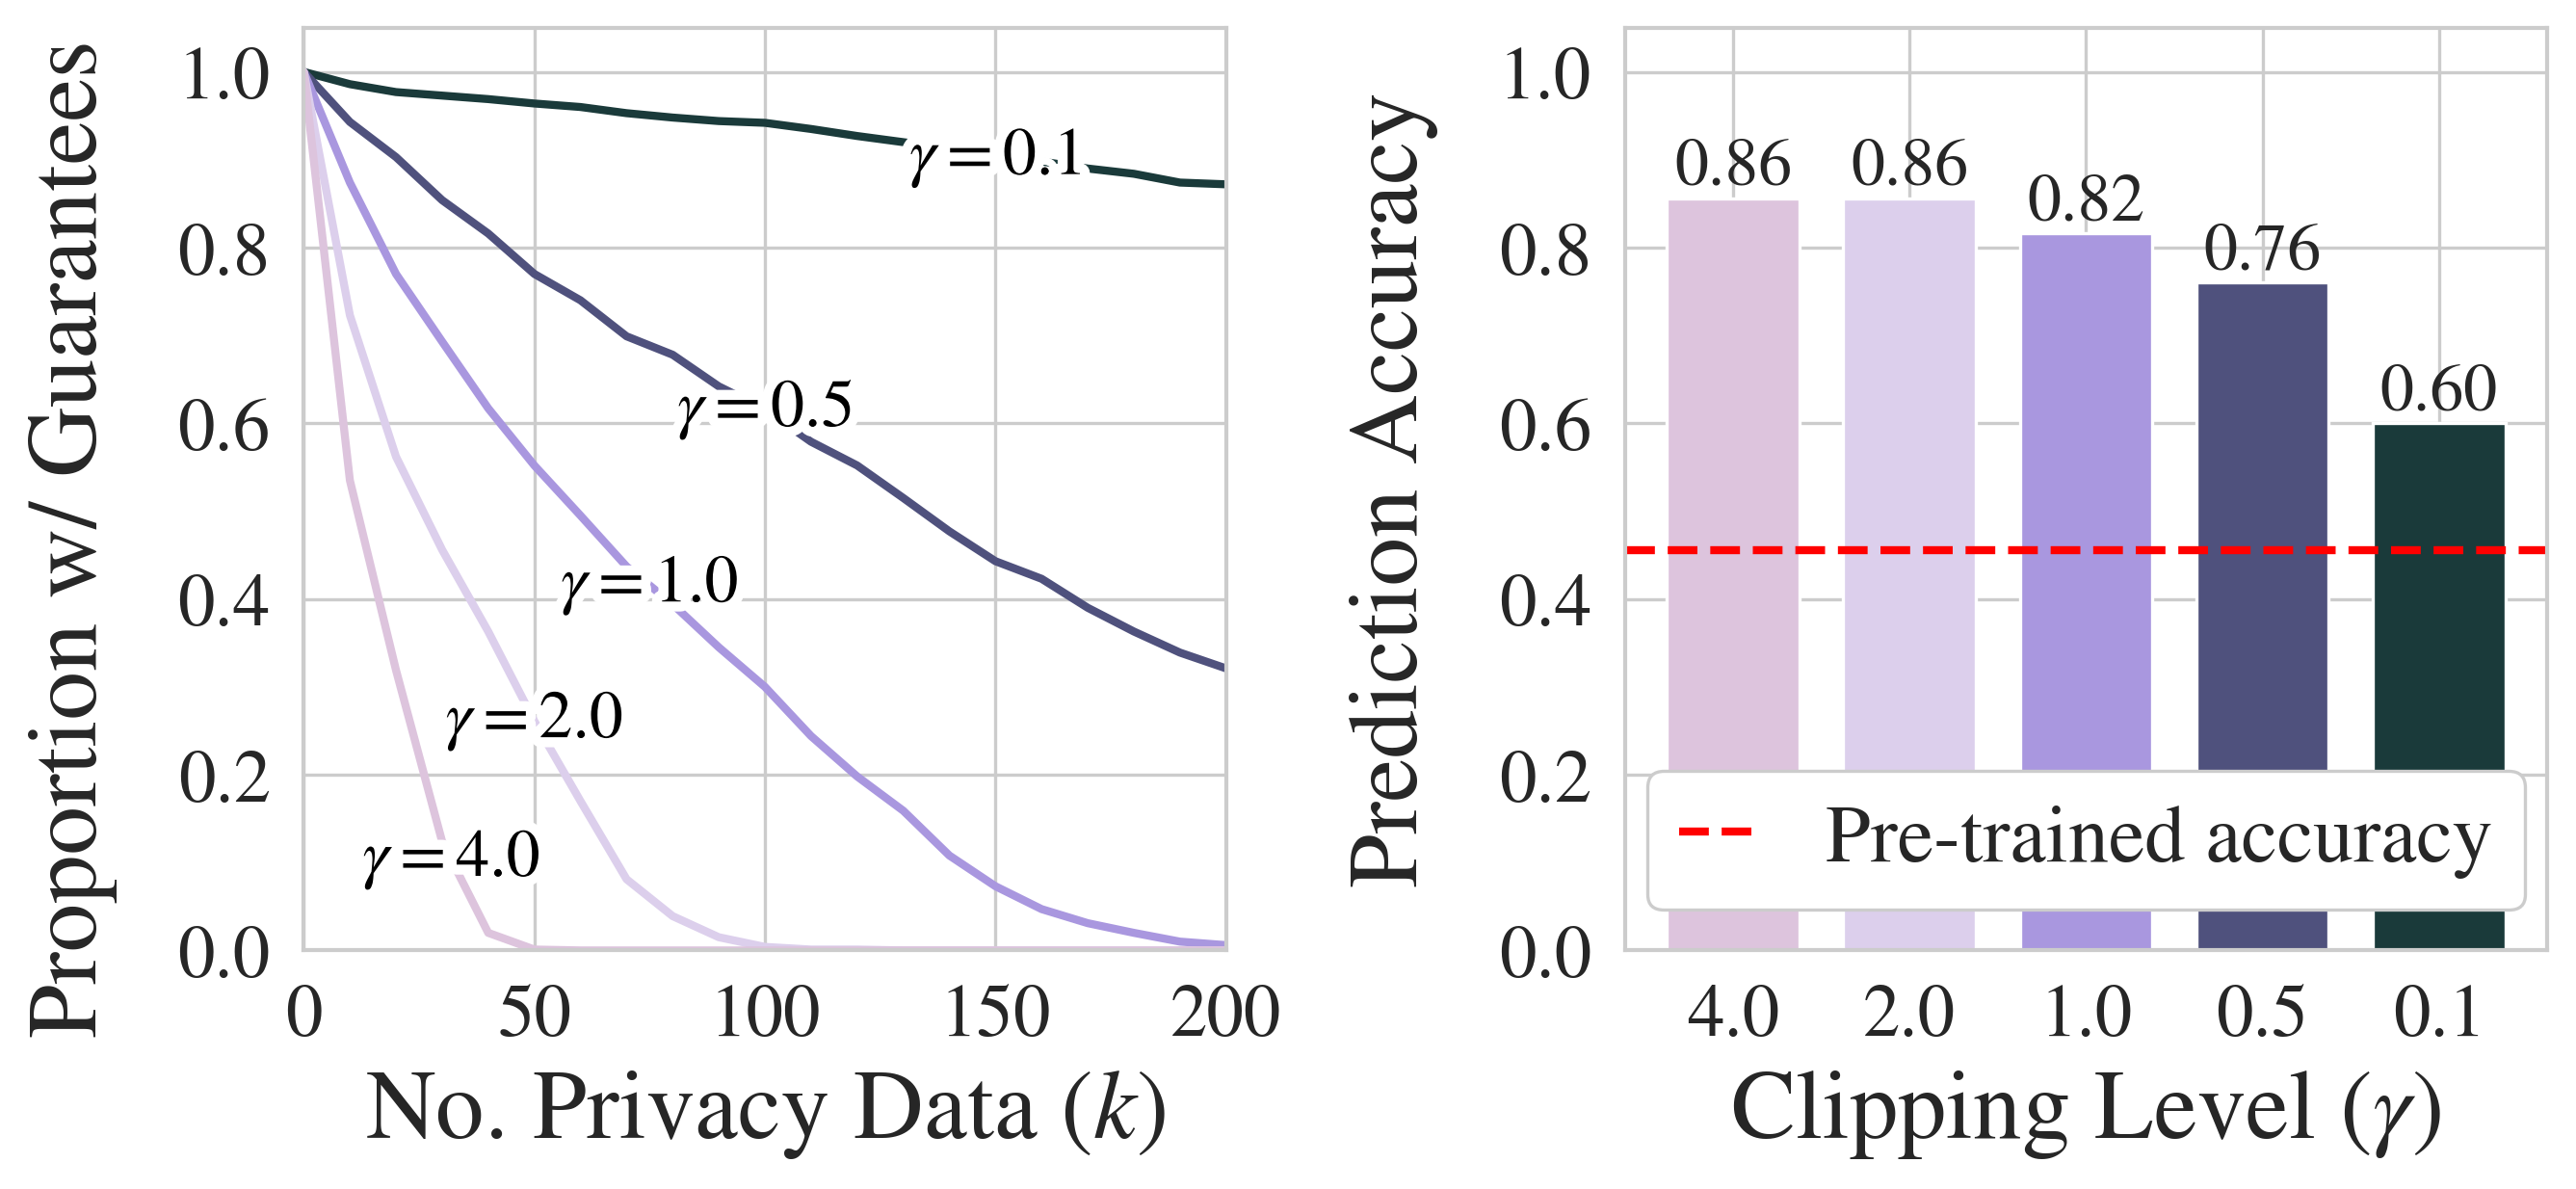

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(9, 4), layout="constrained", width_ratios=[1, 0.01, 1], dpi=300)

axs[1].set_visible(False)
axs[0].set_box_aspect(1)
axs[2].set_box_aspect(1)

for ax in axs:
    ax.set_ylim(0, 1.05)

colours = iter(palette)

for gamma, result in privacy_results.items():
    k_vals = list(result.keys())
    certified_percentages = [r[1] for r in result.values()]
    label = f"$\gamma = {gamma}$" if gamma != math.inf else "$\gamma = \infty$"
    axs[0].plot(k_vals, certified_percentages, color=next(colours), label=label, linewidth=linewidth)
axs[0].set_xlabel("No. Privacy Data ($k$)", fontsize=fontsize)
axs[0].set_ylabel("Proportion w/ Guarantees    ", fontsize=fontsize, labelpad=15)
axs[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[0].set_xlim(0, max(k_private_vals))
labelLines(
    axs[0].get_lines(),
    align=False,
    drop_label=True,
    fontsize=labelsize,
    color="black",
    outline_color="white",
    outline_width=5,
    xvals=[150, 100, 75, 50, 32]
)

# plot the nominal accuracies on the second axis as a bar chart
bar_values = []
gamma_values = [str(g) if g != math.inf else "∞" for g in privacy_results.keys()]
bar_colors = list(reversed(list(iter(palette))[: len(gamma_values)]))
for gamma, result in privacy_results.items():
    nominal_accs = [r[0] for r in result.values()]
    bar_values.append(nominal_accs[0])
bars = axs[2].bar(gamma_values[::-1], bar_values[::-1], color=bar_colors, width=0.75)
axs[2].axhline(pretrain_acc, label="Pre-trained accuracy", color="red", linestyle="--", linewidth=linewidth)
axs[2].set_ylabel("Prediction Accuracy", fontsize=fontsize, labelpad=15)
axs[2].legend(loc="lower center", fontsize="medium", framealpha=1.0, handlelength=1.0)
axs[2].set_xlabel("Clipping Level ($\gamma$)", fontsize=fontsize)

# Add height labels to each bar
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize="small")

plt.savefig(".figures/oct_mnist_privacy.pdf", bbox_inches="tight", dpi=300)